# Project 5: Vehicle Detection Classifiers

## 1.0 Load Data Set

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split

from main.utils import *

%matplotlib inline
    
    
# Read in cars and notcars.
#cars = glob.glob('data/vehicles_smallset/*/*.jpeg')
#notcars = glob.glob('data/non-vehicles_smallset/*/*.jpeg')
cars = glob.glob('data/vehicles/*/*.png')
notcars = glob.glob('data/non-vehicles/*/*.png')

/home/laptop/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 2.0 Extract Features

In [2]:
# Set parameters for feature detection.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 8    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

# Extract features from images.
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Normalize features.
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Define the labels vector.
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets.
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print("Complete")

/home/laptop/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Complete


## 3.0 Train Classifier

In [3]:
# Train a classifier on the data.
svc = LinearSVC()
svc.fit(X_train, y_train)

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Save pickle file.
dist_pickle = dict()
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient 
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins

pickle.dump(dist_pickle, open("svc_pickle.p", "wb"))

Test Accuracy of SVC =  0.9854


## 4.0 Car Class

In [4]:
class VehicleTracker:
    def __init__(self):
        self.rects = []
        self.buffer = 5
        self.cap = 15
        
    def add_frame(self, rects):
        self.rects.append(rects)
        if len(self.rects) > self.cap:
            self.rects.pop(0)

## 5.0 Pipeline (Video)

In [5]:
def pipeline(image):
    
    # Load test image.
    #image = image.astype(np.float32)/255
    draw_image = np.copy(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    rects = []
    
    # Parameters.
    ystart, ystop = 400, 464 
    scale = 1.0
    rects.append(find_cars(draw_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
    ystart, ystop = 400, 550 
    scale = 1.5
    rects.append(find_cars(draw_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart, ystop = 400, 600 
    scale = 2.0
    rects.append(find_cars(draw_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart, ystop = 400, 600 
    scale = 2.5
    rects.append(find_cars(draw_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart, ystop = 400, 640 
    scale = 3.0
    rects.append(find_cars(draw_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart, ystop = 400, 640 
    scale = 3.5
    rects.append(find_cars(draw_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    rects = [item for sublist in rects for item in sublist]
    
    # Update detection.
    if len(rects) > 0:
        tracker.add_frame(rects)
    
    # Update label sets.
    for rect_set in tracker.rects:
        heat = add_heat(heat, rect_set)
        
    if len(tracker.rects) < tracker.buffer:
        heat = apply_threshold(heat, tracker.buffer)
    else:
        heat = apply_threshold(heat, len(tracker.rects))
     
    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

/home/laptop/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


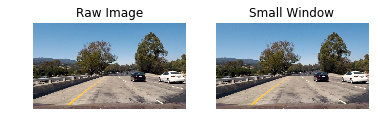

In [25]:
image = mpimg.imread('res/test_images/test1.jpg')


    
# Parameters.
ystart, ystop = 400, 464 
scale = 1.0
rects = (find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

img = draw_boxes(image, rects)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.axis('off')
plt.title('Raw Image')
plt.subplot(122)
plt.imshow(img)
plt.axis('off')
plt.title('Small Window')

[]

## 6.0 Process Video Frames

In [114]:
from moviepy.editor import VideoFileClip

tracker = VehicleTracker()

test_out_file = 'res/project_video_out.mp4'
clip_test = VideoFileClip('res/project_video.mp4')
clip_test_out = clip_test.fl_image(pipeline)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video res/project_video_out.mp4
[MoviePy] Writing video res/project_video_out.mp4


100%|█████████▉| 1260/1261 [06:53<00:00,  2.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: res/project_video_out.mp4 

CPU times: user 6min 54s, sys: 3.23 s, total: 6min 57s
Wall time: 6min 55s
